## The goal of this notebook is to select the most relevant features to predict zhvi (and/or change in) and zri (and/or change in)

In [45]:
from fetch_other_data import get_fed_fund, get_mtg_rate, get_market, get_census, get_irs
from fetch_zillow_data import get_zri, get_zhvi

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import norm, skew
from scipy.stats.stats import pearsonr

import numpy as np

In [2]:
#grab zhvi data
zhvi = get_zhvi(update = False)

In [4]:
#grab mortgage data
mortgage_rate, mortgage_rate_annual = get_mtg_rate(False)

Updated by: freddiemac
date range: 1971-01-01 00:00:00 to 2018-04-01 00:00:00


In [5]:
#30-year mortgage rate offsets
mortgage_rate['30 FRM Rate 1'] = mortgage_rate['30 FRM Rate'].shift(1)
mortgage_rate['30 FRM Rate 6'] = mortgage_rate['30 FRM Rate'].shift(6)
mortgage_rate['30 FRM Rate 12'] = mortgage_rate['30 FRM Rate'].shift(12)
mortgage_rate['30 FRM Rate 24'] = mortgage_rate['30 FRM Rate'].shift(24)

#30-year mortgage month over month percentage changes, and offsets
mortgage_rate['30 FRM Rate pct_change'] = mortgage_rate['30 FRM Rate'].pct_change()
mortgage_rate['30 FRM Rate pct_change 1'] = mortgage_rate['30 FRM Rate pct_change'].shift(1)
mortgage_rate['30 FRM Rate pct_change 6'] = mortgage_rate['30 FRM Rate pct_change'].shift(6)
mortgage_rate['30 FRM Rate pct_change 12'] = mortgage_rate['30 FRM Rate pct_change'].shift(12)
mortgage_rate['30 FRM Rate pct_change 24'] = mortgage_rate['30 FRM Rate pct_change'].shift(24)

In [6]:
#find five zip codes that have higher # of data points
example_zips = list(zhvi[zhvi['Home Type'] == 'All Homes'].groupby('zip')['zhvi'].count().sort_values(ascending = False).index)[:5]

In [7]:
# dataframe with specific zip codes and 'Home Type' == 'All Homes'
temp1_df = zhvi[(zhvi['zip'].isin(example_zips)) & (zhvi['Home Type'] == 'All Homes')]

In [9]:
#possible target is also percentage changes
temp1_df['zhvi pct_change'] = temp1_df.groupby(['Home Type', 'zip']).zhvi.pct_change()

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
#get the targets and features together
temp2_df = pd.merge(temp1_df, mortgage_rate[['30 FRM Rate', '30 FRM Rate 1',
                                             '30 FRM Rate 6', '30 FRM Rate 12',
                                             '30 FRM Rate 24', '30 FRM Rate pct_change',
                                             '30 FRM Rate pct_change 1',
                                             '30 FRM Rate pct_change 6',
                                             '30 FRM Rate pct_change 12',
                                             '30 FRM Rate pct_change 24']],
                    how = 'left', left_index = True, right_index = True)

In [11]:
print(temp2_df[(temp2_df['zip'] == '12077') & (temp2_df['Home Type'] == 'All Homes')].head())

            Home Type    zip      zhvi interp  zhvi pct_change  30 FRM Rate  \
1996-04-01  All Homes  12077  148800.0  False              NaN        7.925   
1996-05-01  All Homes  12077  149900.0  False         0.007392        8.070   
1996-06-01  All Homes  12077  150900.0  False         0.006671        8.320   
1996-07-01  All Homes  12077  151400.0  False         0.003313        8.245   
1996-08-01  All Homes  12077  151100.0  False        -0.001982        8.000   

            30 FRM Rate 1  30 FRM Rate 6  30 FRM Rate 12  30 FRM Rate 24  \
1996-04-01          7.624         7.4750            8.32           8.316   
1996-05-01          7.925         7.3775            7.96           8.600   
1996-06-01          8.070         7.2000            7.57           8.400   
1996-07-01          8.320         7.0300            7.61           8.610   
1996-08-01          8.245         7.0750            7.86           8.510   

            30 FRM Rate pct_change  30 FRM Rate pct_change 1  \
1996

### take a look at the targets and their distributions

14905


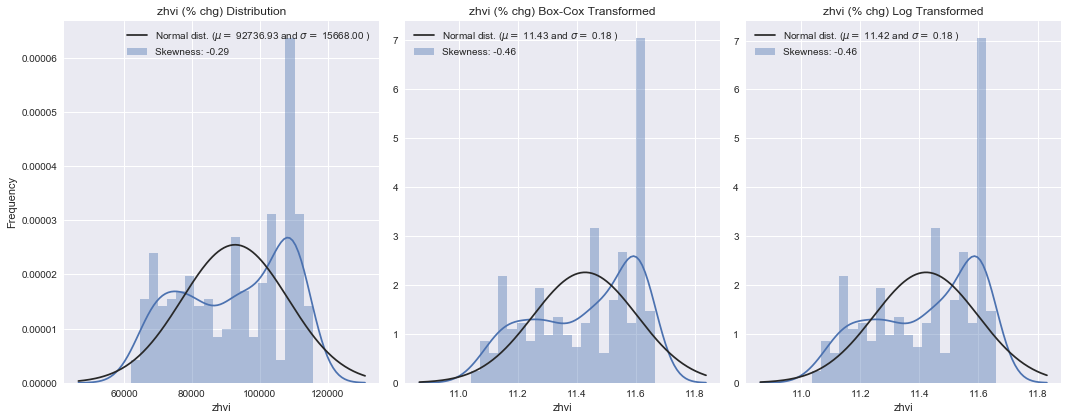

12077


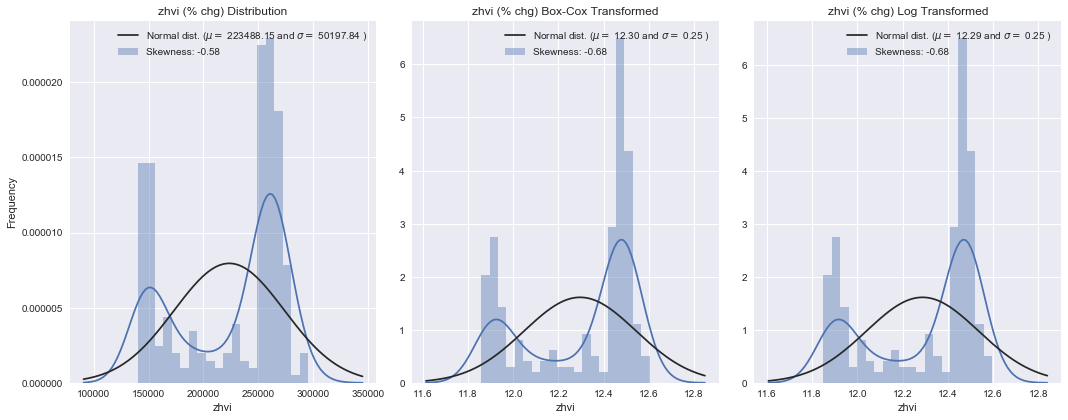

12118


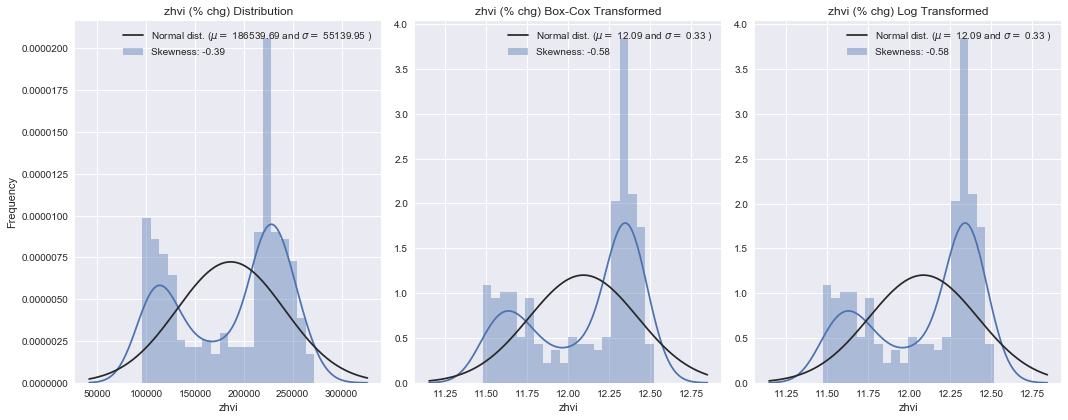

12116


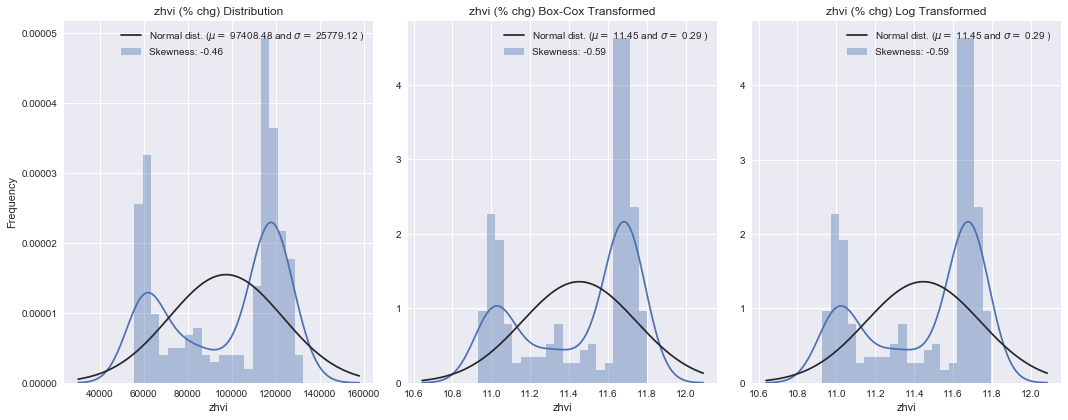

12110


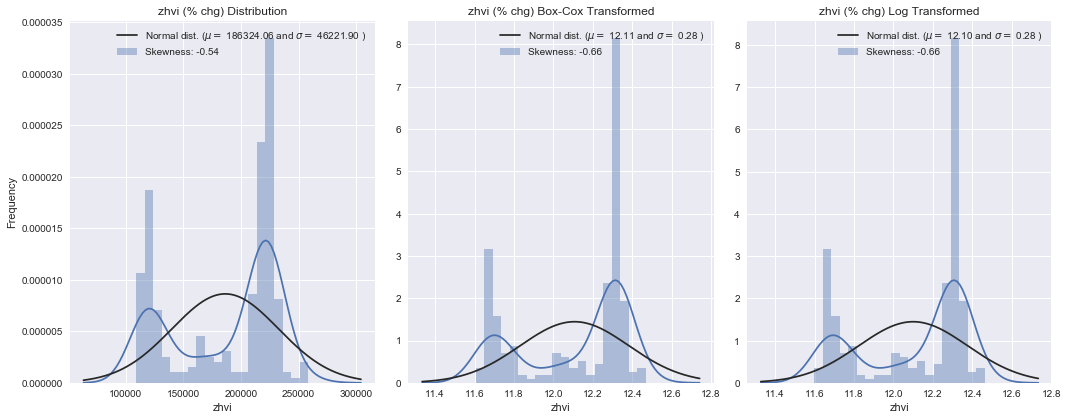

In [22]:
#Target: 'zhvi', trying to correct for skewness
for zipcode in example_zips:
    print(zipcode)
    temp = temp2_df[temp2_df.zip == zipcode]['zhvi'].dropna()
    lam = 0.0001
    fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (15,6))
    sns.distplot(temp, fit = norm, ax = ax1, bins = 20)
    sns.distplot(boxcox1p(temp, lam), fit = norm, ax = ax2, bins = 20)
    sns.distplot(np.log1p(temp), fit = norm, ax = ax3, bins = 20)
    # Get the fitted parameters used by the function
    (mu1, sigma1) = norm.fit(temp)
    (mu2, sigma2) = norm.fit(boxcox1p(temp, lam))
    (mu3, sigma3) = norm.fit(np.log1p(temp))
    ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu1, sigma1),
                'Skewness: {:.2f}'.format(skew(temp))], loc = 'best')
    ax2.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu2, sigma2),
                'Skewness: {:.2f}'.format(skew(boxcox1p(temp, lam)))], loc = 'best')
    ax3.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu3, sigma3),
                'Skewness: {:.2f}'.format(skew(np.log1p(temp)))], loc = 'best')
    ax1.set_ylabel('Frequency')
    ax1.set_title('zhvi (% chg) Distribution')
    ax2.set_title('zhvi (% chg) Box-Cox Transformed')
    ax3.set_title('zhvi (% chg) Log Transformed')
    plt.tight_layout()
    #plt.savefig('zhvi (% chg) Distribution.png')
    plt.show()

14905


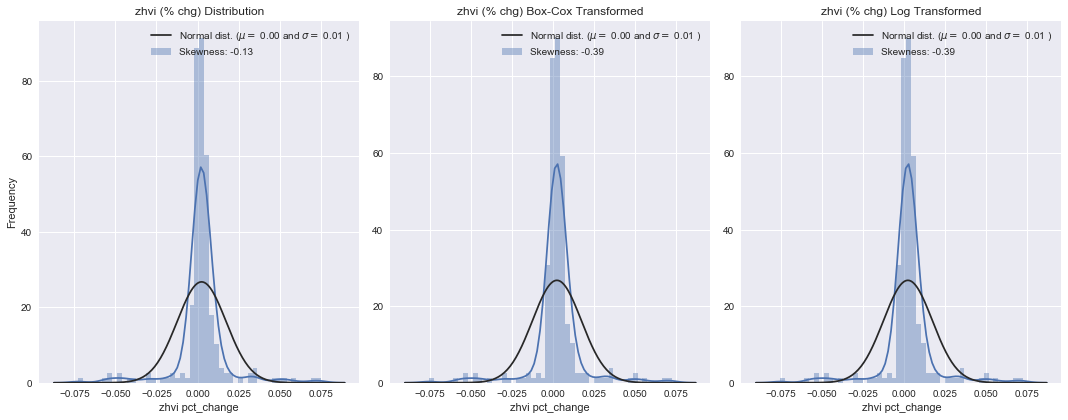

12077


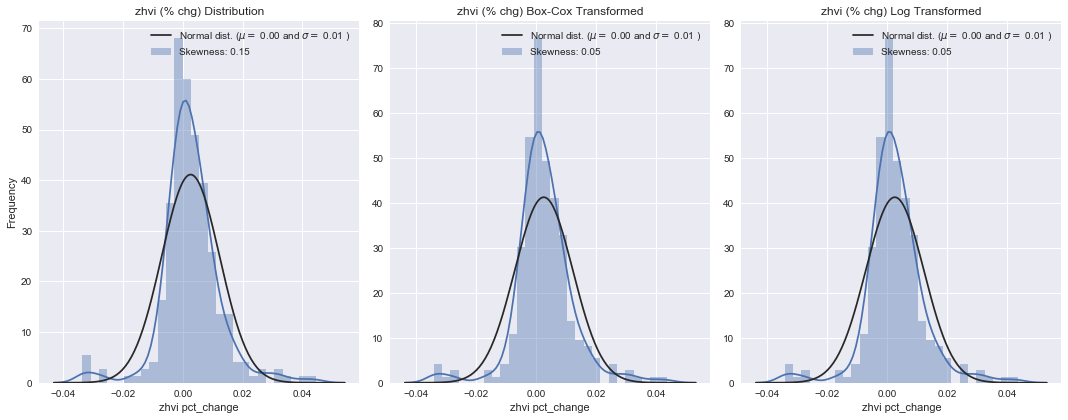

12118


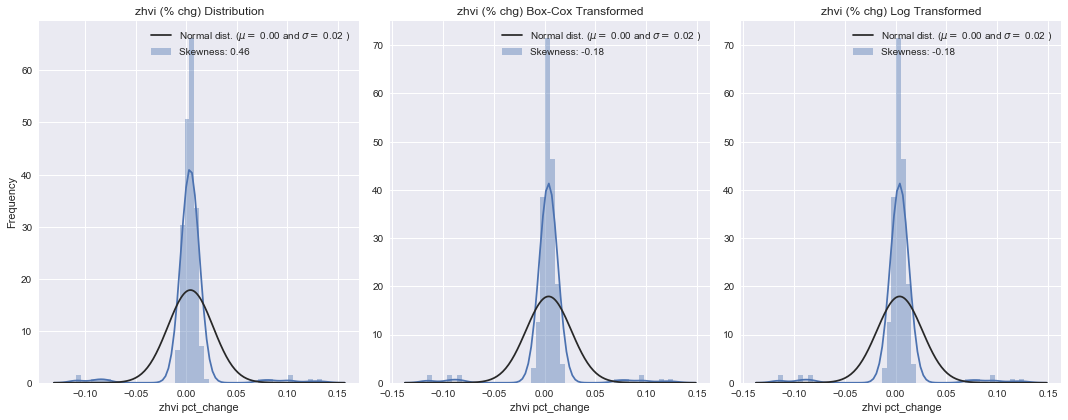

12116


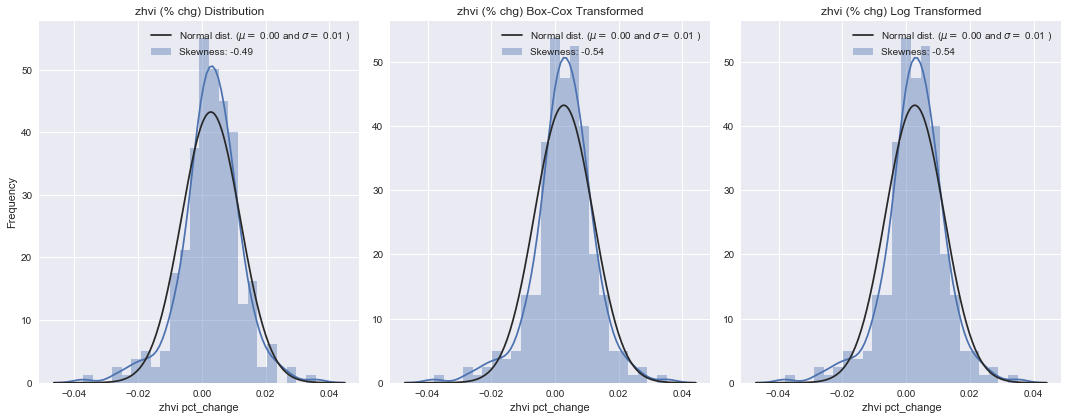

12110


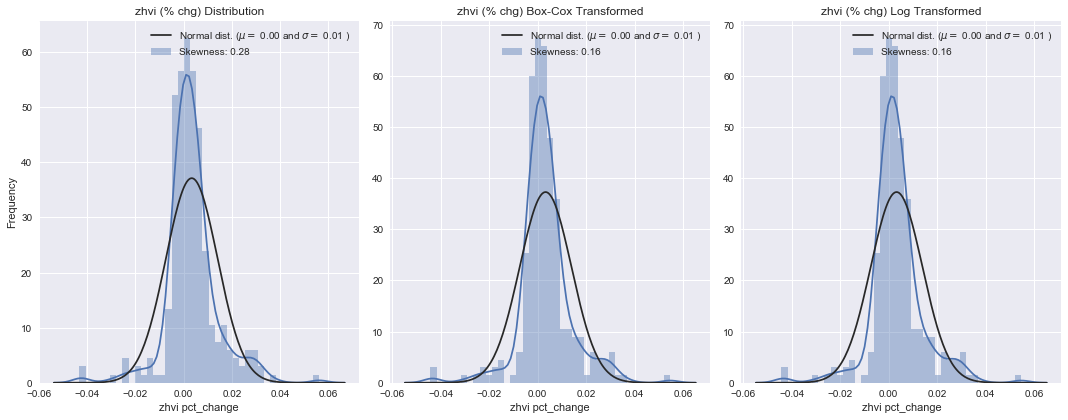

In [20]:
#Target: 'zhvi pct_change', trying to correct for skewness
for zipcode in example_zips:
    print(zipcode)
    temp = temp2_df[temp2_df.zip == zipcode]['zhvi pct_change'].dropna()
    lam = 0.0001
    fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (15,6))
    sns.distplot(temp, fit = norm, ax = ax1)
    sns.distplot(boxcox1p(temp, lam), fit = norm, ax = ax2)
    sns.distplot(np.log1p(temp), fit = norm, ax = ax3)
    # Get the fitted parameters used by the function
    (mu1, sigma1) = norm.fit(temp)
    (mu2, sigma2) = norm.fit(boxcox1p(temp, lam))
    (mu3, sigma3) = norm.fit(np.log1p(temp))
    ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu1, sigma1),
                'Skewness: {:.2f}'.format(skew(temp))], loc = 'best')
    ax2.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu2, sigma2),
                'Skewness: {:.2f}'.format(skew(boxcox1p(temp, lam)))], loc = 'best')
    ax3.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu3, sigma3),
                'Skewness: {:.2f}'.format(skew(np.log1p(temp)))], loc = 'best')
    ax1.set_ylabel('Frequency')
    ax1.set_title('zhvi (% chg) Distribution')
    ax2.set_title('zhvi (% chg) Box-Cox Transformed')
    ax3.set_title('zhvi (% chg) Log Transformed')
    plt.tight_layout()
    #plt.savefig('zhvi (% chg) Distribution.png')
    plt.show()

### Doesn't seem like the target(s) need transformation. How about some reatures?

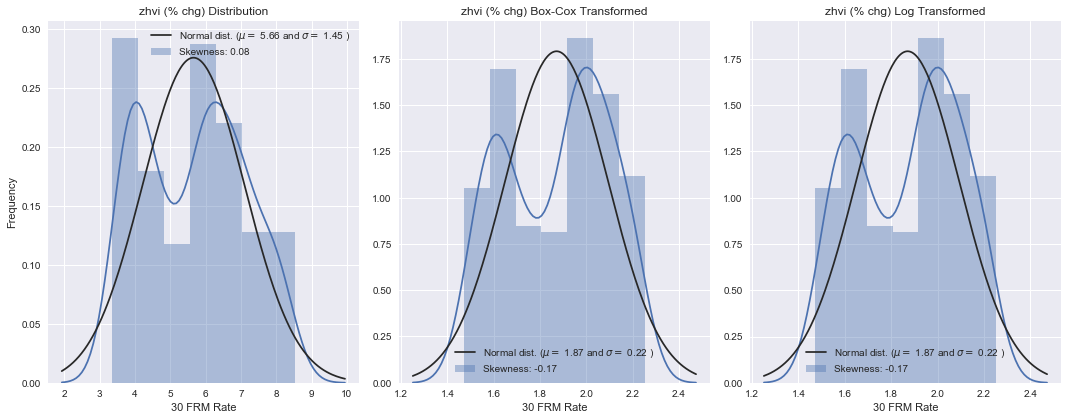

In [27]:
#Feature: '30 FRM Rate', trying to correct for skewness
zipcode = example_zips[0]
temp = temp2_df[temp2_df.zip == zipcode]['30 FRM Rate'].dropna()
lam = 0.0001
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (15,6))
sns.distplot(temp, fit = norm, ax = ax1)
sns.distplot(boxcox1p(temp, lam), fit = norm, ax = ax2)
sns.distplot(np.log1p(temp), fit = norm, ax = ax3)
# Get the fitted parameters used by the function
(mu1, sigma1) = norm.fit(temp)
(mu2, sigma2) = norm.fit(boxcox1p(temp, lam))
(mu3, sigma3) = norm.fit(np.log1p(temp))
ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu1, sigma1),
            'Skewness: {:.2f}'.format(skew(temp))], loc = 'best')
ax2.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu2, sigma2),
            'Skewness: {:.2f}'.format(skew(boxcox1p(temp, lam)))], loc = 'best')
ax3.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu3, sigma3),
            'Skewness: {:.2f}'.format(skew(np.log1p(temp)))], loc = 'best')
ax1.set_ylabel('Frequency')
ax1.set_title('zhvi (% chg) Distribution')
ax2.set_title('zhvi (% chg) Box-Cox Transformed')
ax3.set_title('zhvi (% chg) Log Transformed')
plt.tight_layout()
plt.show()

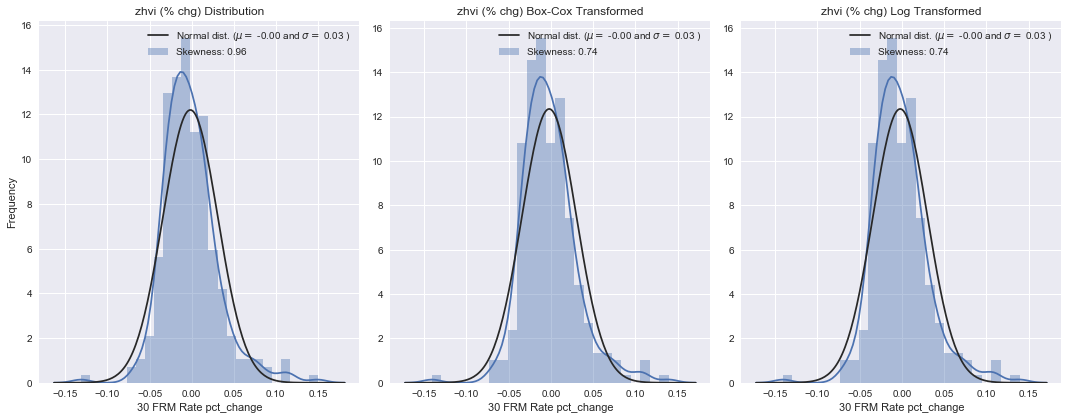

In [28]:
#Feature: '30 FRM Rate pct_change', trying to correct for skewness
zipcode = example_zips[0]
temp = temp2_df[temp2_df.zip == zipcode]['30 FRM Rate pct_change'].dropna()
lam = 0.0001
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (15,6))
sns.distplot(temp, fit = norm, ax = ax1)
sns.distplot(boxcox1p(temp, lam), fit = norm, ax = ax2)
sns.distplot(np.log1p(temp), fit = norm, ax = ax3)
# Get the fitted parameters used by the function
(mu1, sigma1) = norm.fit(temp)
(mu2, sigma2) = norm.fit(boxcox1p(temp, lam))
(mu3, sigma3) = norm.fit(np.log1p(temp))
ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu1, sigma1),
            'Skewness: {:.2f}'.format(skew(temp))], loc = 'best')
ax2.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu2, sigma2),
            'Skewness: {:.2f}'.format(skew(boxcox1p(temp, lam)))], loc = 'best')
ax3.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu3, sigma3),
            'Skewness: {:.2f}'.format(skew(np.log1p(temp)))], loc = 'best')
ax1.set_ylabel('Frequency')
ax1.set_title('zhvi (% chg) Distribution')
ax2.set_title('zhvi (% chg) Box-Cox Transformed')
ax3.set_title('zhvi (% chg) Log Transformed')
plt.tight_layout()
plt.show()

### Take a look if the features have any linear relationship with the target

14905
30 FRM Rate v. zhvi:  (-0.925791297227468, 1.0939056397280158e-112)
30 FRM Rate 1 v. zhvi:  (-0.9253931330767768, 2.147040190049593e-112)
30 FRM Rate 6 v. zhvi:  (-0.9160277426552982, 6.117583267372075e-106)
30 FRM Rate 12 v. zhvi:  (-0.9118887533152586, 2.5281909947672233e-103)
30 FRM Rate 24 v. zhvi:  (-0.9188281386337422, 8.683307769378987e-108)
12077
30 FRM Rate v. zhvi:  (-0.775386567267174, 3.1421441841258555e-54)
30 FRM Rate 1 v. zhvi:  (-0.7768105544216432, 1.5143330185880362e-54)
30 FRM Rate 6 v. zhvi:  (-0.7781384701664888, 7.629322290848583e-55)
30 FRM Rate 12 v. zhvi:  (-0.7836503886220136, 4.209704490045261e-56)
30 FRM Rate 24 v. zhvi:  (-0.7926579854280512, 3.0656608232743716e-58)
12118
30 FRM Rate v. zhvi:  (-0.8686940597663274, 6.602869688860244e-82)
30 FRM Rate 1 v. zhvi:  (-0.8700429236546158, 1.8735067668012215e-82)
30 FRM Rate 6 v. zhvi:  (-0.8688241046460453, 5.851313325263767e-82)
30 FRM Rate 12 v. zhvi:  (-0.8701386266959968, 1.71240779563919e-82)
30 FRM Ra

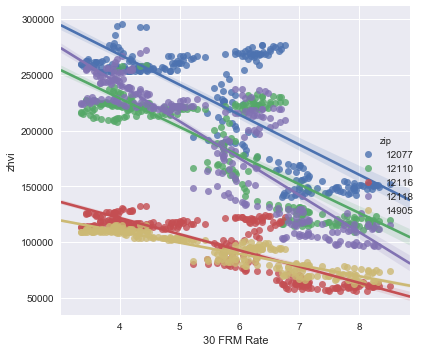

In [50]:
sns.lmplot(data = temp2_df, x = '30 FRM Rate', y = 'zhvi', hue = 'zip')
plt.tight_layout()
for zipcode in example_zips:
    print(zipcode)
    for col in ['30 FRM Rate', '30 FRM Rate 1', '30 FRM Rate 6', '30 FRM Rate 12', '30 FRM Rate 24']:
        print('{} v. zhvi: '.format(col), pearsonr(temp2_df[temp2_df.zip == zipcode]['zhvi'], 
                                                   temp2_df[temp2_df.zip == zipcode][col]))

14905


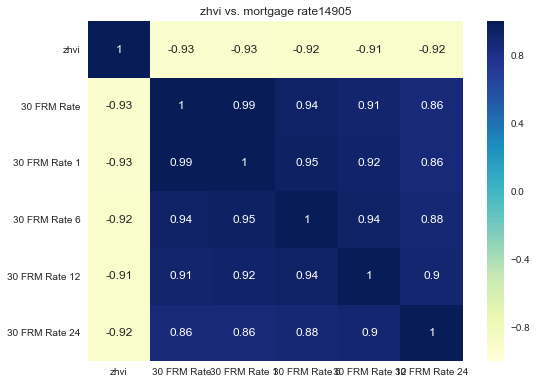

12077


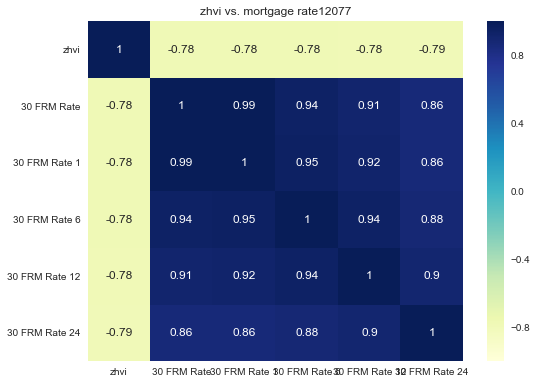

12118


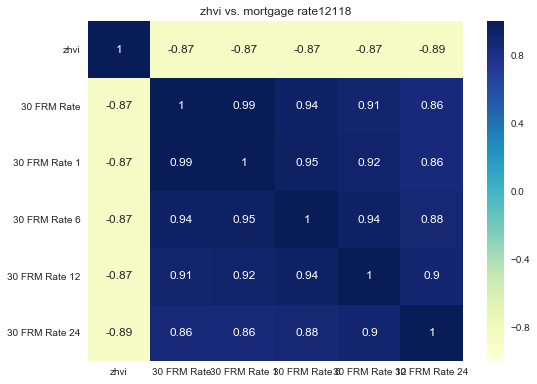

12116


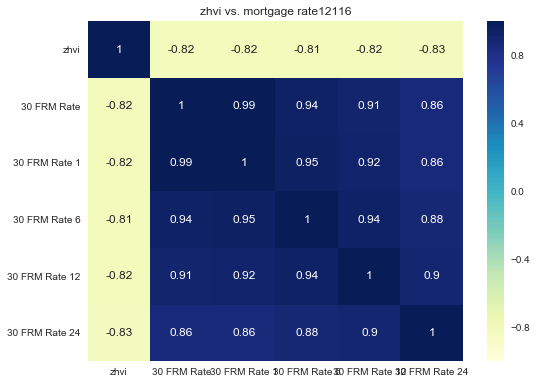

12110


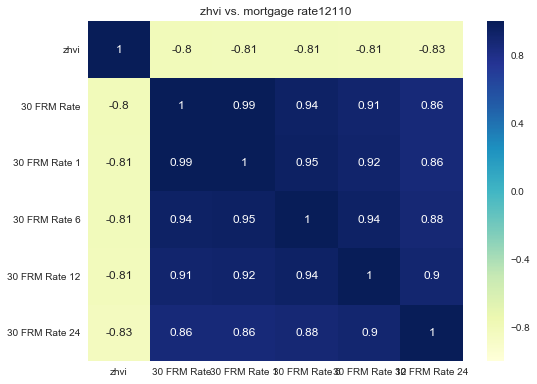

In [14]:
for zipcode in example_zips:
    print(zipcode)
    heatmap1 = temp2_df[temp2_df.zip == zipcode][['zhvi', '30 FRM Rate', '30 FRM Rate 1',
                                                  '30 FRM Rate 6', '30 FRM Rate 12',
                                                  '30 FRM Rate 24']].corr()
    sns.heatmap(heatmap1, annot = True, cmap = "YlGnBu")
    plt.yticks(rotation = 0) 
    plt.title('zhvi vs. mortgage rate' + zipcode)
    plt.tight_layout()
    plt.show()

14905
30 FRM Rate pct_change v. zhvi % change:  (-0.008226828452522377, 0.8943646173818521)
30 FRM Rate pct_change 1 v. zhvi % change:  (0.04261410238118871, 0.4913863895101729)
30 FRM Rate pct_change 6 v. zhvi % change:  (-0.07243144352806022, 0.2417661793771669)
30 FRM Rate pct_change 12 v. zhvi % change:  (-0.04757866154960593, 0.44227561921951075)
30 FRM Rate pct_change 24 v. zhvi % change:  (0.01153335192882111, 0.8523233630430602)
12077
30 FRM Rate pct_change v. zhvi % change:  (-0.030889024557228213, 0.6180127854211801)
30 FRM Rate pct_change 1 v. zhvi % change:  (0.053105954158911145, 0.3910377065184234)
30 FRM Rate pct_change 6 v. zhvi % change:  (0.026106901273837937, 0.6734353157151112)
30 FRM Rate pct_change 12 v. zhvi % change:  (0.008719015215940918, 0.8880849676259216)
30 FRM Rate pct_change 24 v. zhvi % change:  (0.10057647167974743, 0.10364449749800655)
12118
30 FRM Rate pct_change v. zhvi % change:  (0.04772173251474586, 0.4409029914480972)
30 FRM Rate pct_change 1 v.

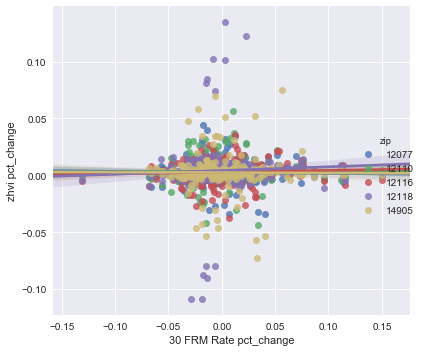

In [57]:
sns.lmplot(data = temp2_df, x = '30 FRM Rate pct_change', y = 'zhvi pct_change', hue = 'zip')
plt.tight_layout()

for zipcode in example_zips:
    print(zipcode)
    for col in ['30 FRM Rate pct_change', '30 FRM Rate pct_change 1', '30 FRM Rate pct_change 6', 
                '30 FRM Rate pct_change 12', '30 FRM Rate pct_change 24']:
        temp = temp2_df[temp2_df.zip == zipcode][[col, 'zhvi pct_change']].dropna()
        print('{} v. zhvi % change: '.format(col), pearsonr(temp['zhvi pct_change'], temp[col]))

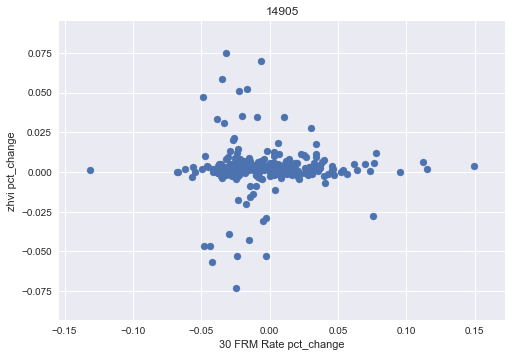

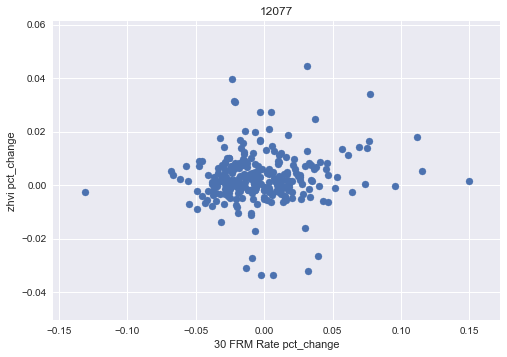

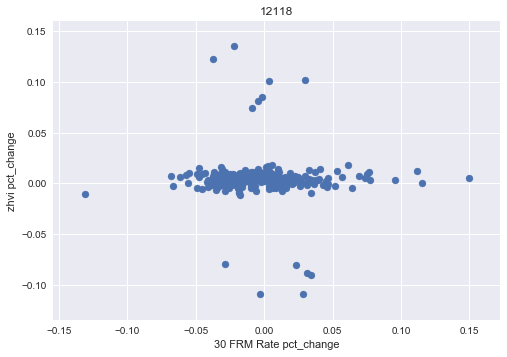

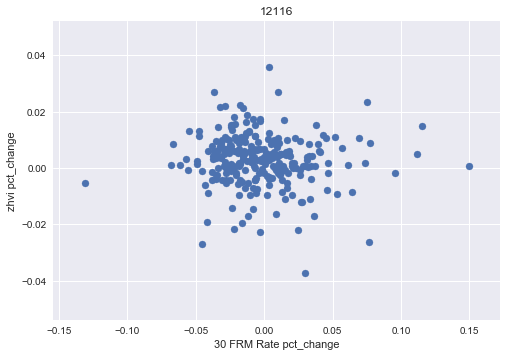

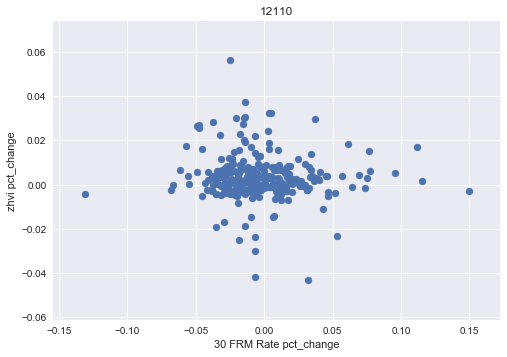

In [15]:
for zipcode in example_zips:
    plt.scatter(x = temp2_df[temp2_df.zip == zipcode]['30 FRM Rate pct_change 24'],
                y = temp2_df[temp2_df.zip == zipcode]['zhvi pct_change'])
    plt.title(zipcode)
    plt.xlabel('30 FRM Rate pct_change')
    plt.ylabel('zhvi pct_change')
    plt.show()

14905


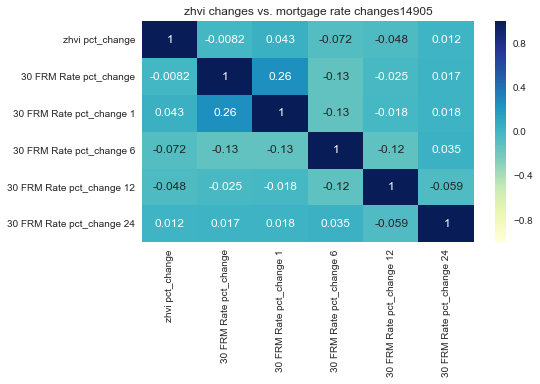

12077


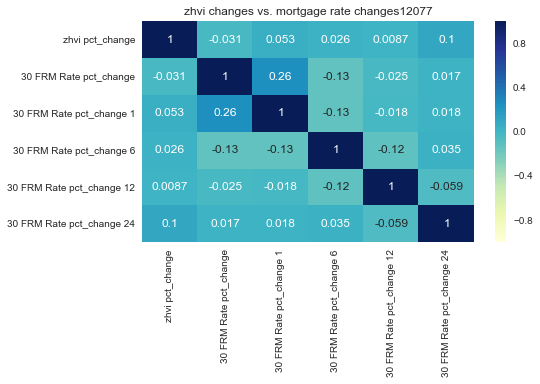

12118


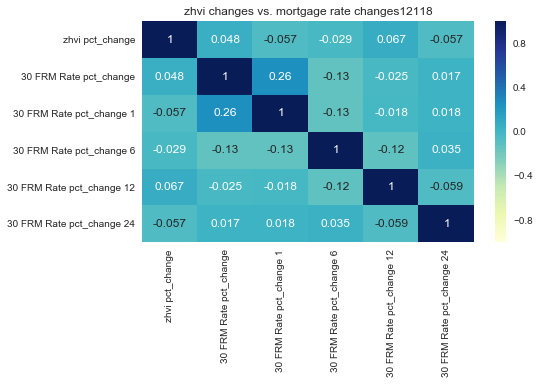

12116


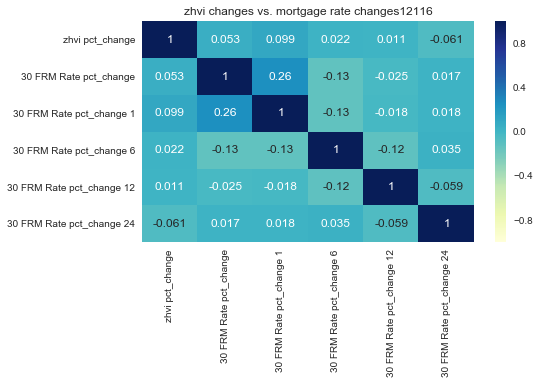

12110


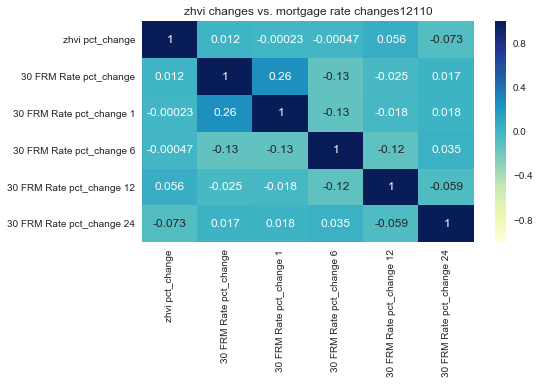

In [16]:
for zipcode in example_zips:
    print(zipcode)
    heatmap2 = temp2_df[temp2_df.zip == zipcode][['zhvi pct_change', '30 FRM Rate pct_change', '30 FRM Rate pct_change 1',
                                                  '30 FRM Rate pct_change 6', '30 FRM Rate pct_change 12',
                                                  '30 FRM Rate pct_change 24']].corr()
    sns.heatmap(heatmap2, annot = True, cmap = "YlGnBu")
    plt.yticks(rotation = 0) 
    plt.title('zhvi changes vs. mortgage rate changes' + zipcode)
    plt.tight_layout()
    plt.show()